In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy.signal import savgol_filter
import seaborn as sns
import ast
sns.set()

# Trajectories (obs, actions, penalty)

In [3]:
!ls ../results/2_new_NN_architecture/4_results_report/3_immersion_goood/standby_0

gpu_10	gpu_15	gpu_5


In [4]:
!ls ../results/2_new_NN_architecture/4_results_report/0_air/standby_0

gpu_10	gpu_15	gpu_5  res  res_2


In [6]:
path = "../results/2_new_NN_architecture/4_results_report/3_immersion_goood/standby_2/gpu_10/"
#path = "../data/"
#path = "../results/new_folder/"
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",
                "action", "penalty"]
df = pd.read_csv(path+'a3c/a3c_trajectories_0.csv',
                 delimiter=";",
                 names=COLUMN_NAMES,

                )
df.head()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty
0,-2.949946,-4.875729,-5.148372,-4.875729,-2.949946,-4.875729,-5.148372,-4.875729,-2.949946,-4.875729,-5.148372,-4.875729,edc_2,False
1,-2.949946,-4.875729,-5.148372,-4.875729,-2.949946,-4.875729,-5.148372,-4.875729,-2.949946,-4.875729,-5.148372,-4.875729,edc_2,False
2,-2.949946,-4.143562,-4.370378,-4.921557,-2.949946,-4.143562,-4.370378,-4.921557,-2.949946,-4.143562,-4.370378,-4.921557,edc_2,False
3,-2.949946,-4.143562,-4.370378,-4.921557,-2.949946,-4.143562,-4.370378,-4.921557,-2.725288,-4.091402,-4.308651,-4.931123,edc_2,False
4,-2.949946,-4.143562,-4.370378,-4.921557,-2.949946,-4.143562,-4.370378,-4.921557,-2.500629,-4.025205,-4.232293,-4.941284,edc_2,False


In [7]:
gpus_per_edc = 10
scale_dict = {"normalization": {gpus_per_edc: {"power": (58*gpus_per_edc, 80*gpus_per_edc),
                                                        "util": (0, 100*gpus_per_edc),
                                                        "dist": (299.58, 2186.21)
                                                        },
                                        },
               "standarization": {5: {"power": (361.19, 25.89),
                                      "util": (268.08, 111.47),
                                      "dist": (1088.39, 540.25)
                                      },
                                  10: {"power": (944.16, 183.39),
                                       "util": (656.54, 222.56),
                                       "dist": (1088.39, 540.25)
                                       },
                                 }
                      }
scale_mode = "standarization"
scale_factor = gpus_per_edc


def inverse_scale_data(scale_data):
        if scale_mode == "normalization":
            return scale_data * (scale_pair[1] - scale_pair[0]) + scale_pair[0]
        if scale_mode == "standarization":
            return scale_data * scale_pair[1] + scale_pair[0]
        return scale_data
        
scaled_col = COLUMN_NAMES[:-2]

scaled_df = df.copy()
scale_pair = scale_dict[scale_mode][scale_factor]["util"]
scaled_df[scaled_col[0::4]] = scaled_df[scaled_col[0::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[1::4]] = scaled_df[scaled_col[1::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[2::4]] = scaled_df[scaled_col[2::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[3::4]] = scaled_df[scaled_col[3::4]].apply(inverse_scale_data)

for i in range(3):
    scaled_df["pue_"+str(i)] = scaled_df["power_"+str(i)] / scaled_df["it_"+str(i)]
    
#scaled_df["total_pue"] = (scaled_df["pue_0"] + scaled_df["pue_1"] + scaled_df["pue_2"])/3

scaled_df["total_power"] = scaled_df["power_0"] + scaled_df["power_1"] + scaled_df["power_2"]
scaled_df["total_it"] = scaled_df["it_0"] + scaled_df["it_1"] + scaled_df["it_2"]
scaled_df["total_cool"] = scaled_df["cool_0"] + scaled_df["cool_1"] + scaled_df["cool_2"]
scaled_df["total_util"] = scaled_df["util_0"] + scaled_df["util_1"] + scaled_df["util_2"]
scaled_df["total_pue"] = scaled_df["total_power"] / scaled_df["total_it"]

scaled_df = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

scaled_df.describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_power,total_it,total_cool,total_util,total_pue
count,2.346000e+03,2346.000000,2.346000e+03,2346.000000,2.346000e+03,2346.000000,2.346000e+03,2346.000000,2.346000e+03,2346.000000,2.346000e+03,2346.000000,2.346000e+03,2.346000e+03,2.346000e+03,2346.000000,2346.000000,2346.000000,2346.000000,2.346000e+03
mean,7.917733e+00,200.980944,1.614671e+02,39.513875,1.858056e+02,386.595673,3.589623e+02,27.633387,8.976236e+02,946.672560,9.171921e+02,29.480480,6.945440e+04,6.945423e+04,6.945418e+04,1534.249176,1437.621437,96.627741,1091.346974,6.945421e+04
std,1.483460e+01,29.975059,3.363047e+01,3.663460,5.641125e+01,61.632769,6.457056e+01,3.188581,1.178813e+02,44.809117,4.493546e+01,1.108534,2.378200e+06,2.378200e+06,2.378200e+06,93.707955,97.781622,5.183013,139.238094,2.378200e+06
min,3.516609e-07,50.000001,6.137338e-07,32.593262,3.516609e-07,50.000001,6.137338e-07,25.778678,3.516609e-07,50.000001,6.137338e-07,25.109258,1.143788e+00,1.060811e+00,1.031714e+00,150.000002,0.000002,86.793472,0.000001,1.056525e+00
25%,3.516609e-07,184.272196,1.426765e+02,40.687513,1.750000e+02,355.009047,3.270818e+02,26.050877,8.500000e+02,941.079248,9.119709e+02,29.120967,1.274292e+00,1.063981e+00,1.031944e+00,1503.491342,1404.137742,95.509721,1050.000000,1.065163e+00
50%,3.516609e-07,184.272196,1.426765e+02,41.595744,2.000000e+02,416.778789,3.904198e+02,26.359005,9.250000e+02,957.490760,9.277208e+02,29.769965,1.291539e+00,1.067515e+00,1.032089e+00,1566.024627,1471.389169,97.358748,1125.000000,1.066050e+00
75%,3.516609e-07,189.024023,1.483365e+02,41.595744,2.250000e+02,433.219143,4.071683e+02,27.927237,9.750000e+02,964.439682,9.343795e+02,30.060205,1.291539e+00,1.085383e+00,1.032171e+00,1578.879856,1481.961305,98.691964,1175.000000,1.070758e+00
max,5.000000e+01,259.269623,2.266764e+02,50.000001,3.000000e+02,449.695426,4.239167e+02,50.000001,1.000000e+03,967.664681,9.374677e+02,50.000001,8.146854e+07,8.146854e+07,8.146854e+07,1657.739503,1569.049386,150.000002,1250.000000,8.146854e+07


# Baseline Comparison

In [8]:
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",]
df_2 = pd.read_csv(path+'closest_trajectory.csv',
                 delimiter=";",
                 names=COLUMN_NAMES)
for i in range(3):
    df_2["pue_"+str(i)] = df_2["power_"+str(i)] / df_2["it_"+str(i)]

for col in ["power", "it", "cool", "util"]:
    df_2["total_"+col] = df_2[col+"_0"] + df_2[col+"_1"] + df_2[col+"_2"]
    
#df_2["total_pue"] = (df_2["pue_0"] + df_2["pue_1"] + df_2["pue_2"])/3
df_2["total_pue"] = df_2["total_power"] / df_2["total_it"] 

df_2 = df_2[~df_2.isin([np.nan, np.inf, -np.inf]).any(1)]

df_2.describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_power,total_it,total_cool,total_util,total_pue
count,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.00000,2281.000000
mean,391.286716,635.162861,610.539774,24.623087,425.010960,668.558612,643.888351,24.670260,149.276633,334.479883,305.575569,28.904314,1.040927,1.038881,1.097534,1638.201356,1560.003694,78.197661,965.57431,1.050728
std,100.829778,57.952986,58.171404,0.581549,120.371546,59.631067,59.788069,0.569881,58.104400,39.235233,40.973313,1.813755,0.009052,0.008967,0.023371,124.314664,126.049252,2.361924,239.26500,0.009390
min,0.000000,184.272196,142.676453,24.493985,0.000000,184.272196,142.676453,24.493985,0.000000,184.272196,142.676453,26.050876,1.035596,1.035198,1.063981,552.816588,428.029358,75.293483,0.00000,1.044039
25%,325.000000,602.444117,577.913315,24.502421,325.000000,637.160414,612.666405,24.527955,125.000000,320.214490,291.012962,27.833063,1.037255,1.035860,1.084299,1573.576167,1494.796333,77.153616,775.00000,1.047087
50%,400.000000,632.816458,608.322105,24.552319,450.000000,687.325195,662.738503,24.646135,175.000000,345.573716,317.334953,28.238762,1.040265,1.037099,1.088987,1666.770077,1588.877899,77.538303,1025.00000,1.048828
75%,475.000000,684.225642,659.650330,24.646985,525.000000,713.949424,689.233841,24.734271,200.000000,358.003046,330.169983,29.201527,1.042447,1.039979,1.100344,1717.686697,1640.560959,78.370159,1175.00000,1.052414
max,550.000000,720.163917,695.410187,41.595743,600.000000,729.977273,705.157043,41.595743,225.000000,433.219143,407.168266,41.595743,1.291539,1.291539,1.291539,1788.547245,1710.900558,124.787230,1250.00000,1.291539


In [9]:
df_results = pd.DataFrame()

df_results["e-power"] = scaled_df.describe()["total_power"]
df_results["c-power"] = df_2.describe()["total_power"]
df_results["saving-power"] = (1 - df_results["e-power"]/df_results["c-power"])*100

df_results["e-pue"] = scaled_df.iloc[15:].describe()["total_pue"]
df_results["c-pue"] = df_2.iloc[15:].describe()["total_pue"]
df_results["saving-pue"] = (1-df_results["e-pue"]/df_results["c-pue"])*100

df_results

,e-power,c-power,saving-power,e-pue,c-pue,saving-pue
count,2346.000000,2281.000000,-2.849627,2331.000000,2266.000000,-2.868491
mean,1534.249176,1638.201356,6.345507,1.067316,1.050462,-1.604367
std,93.707955,124.314664,24.620352,0.007242,0.005511,-31.409053
min,150.000002,552.816588,72.866226,1.056525,1.044039,-1.195904
25%,1503.491342,1573.576167,4.453857,1.065006,1.047087,-1.711331
50%,1566.024627,1666.770077,6.044352,1.066050,1.048830,-1.641846
75%,1578.879856,1717.686697,8.081034,1.070758,1.052410,-1.743417
max,1657.739503,1788.547245,7.313631,1.104720,1.087323,-1.599979


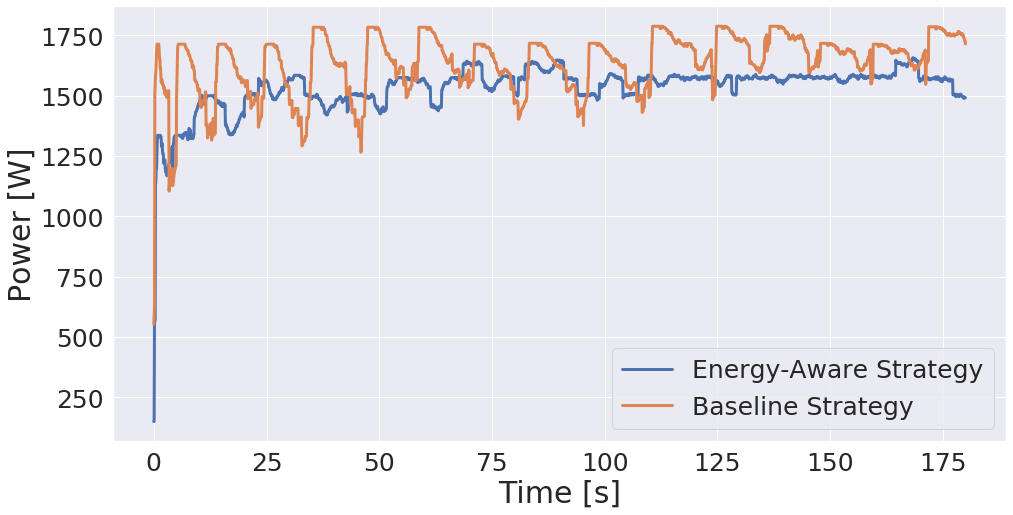

In [10]:
sim_time = 180
time_scaled = np.linspace(0, sim_time, len(scaled_df))
time_2 = np.linspace(0, sim_time, len(df_2))


plt.figure(figsize=(16,8))
plt.plot(time_scaled, scaled_df["total_power"], label="Energy-Aware Strategy", linewidth=3)
plt.plot(time_2, df_2["total_power"], label="Baseline Strategy", linewidth=3)
plt.ylabel("Power [W]", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

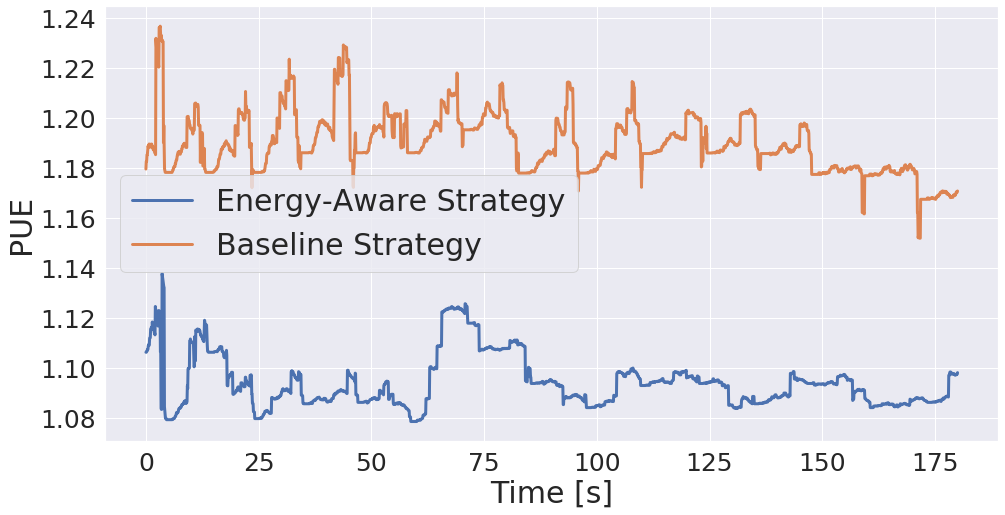

In [284]:
sim_time = 180
off=15
time_scaled = np.linspace(0, sim_time, len(scaled_df)-off)
time_2 = np.linspace(0, sim_time, len(df_2)-off)


plt.figure(figsize=(16,8))
plt.plot(time_scaled, scaled_df["total_pue"][off:], label="Energy-Aware Strategy", linewidth=3)
plt.plot(time_2, df_2["total_pue"][off:], label="Baseline Strategy", linewidth=3)
plt.ylabel("PUE", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

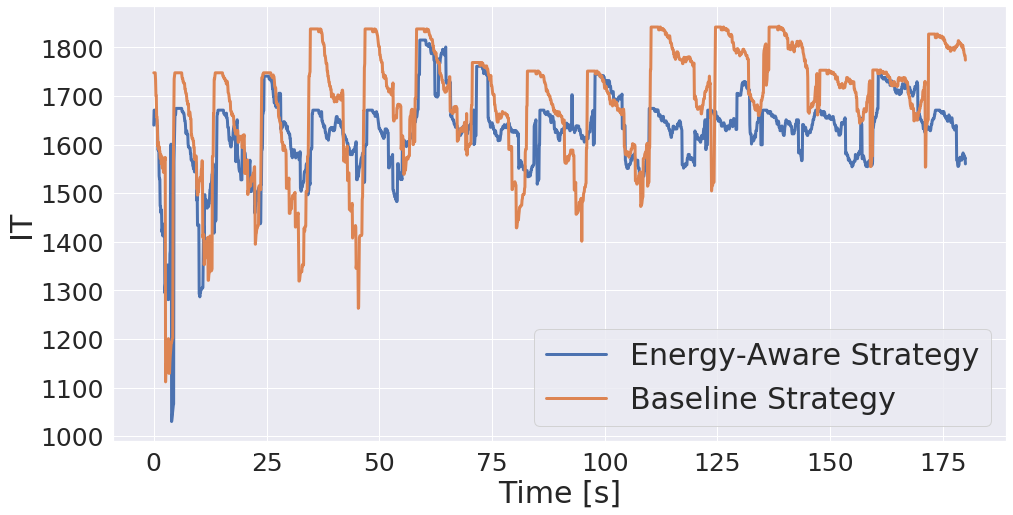

In [285]:
sim_time = 180
off=10
time_scaled = np.linspace(0, sim_time, len(scaled_df)-off)
time_2 = np.linspace(0, sim_time, len(df_2)-off)


plt.figure(figsize=(16,8))
plt.plot(time_scaled, scaled_df["total_it"][off:], label="Energy-Aware Strategy", linewidth=3)
plt.plot(time_2, df_2["total_it"][off:], label="Baseline Strategy", linewidth=3)
plt.ylabel("IT", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

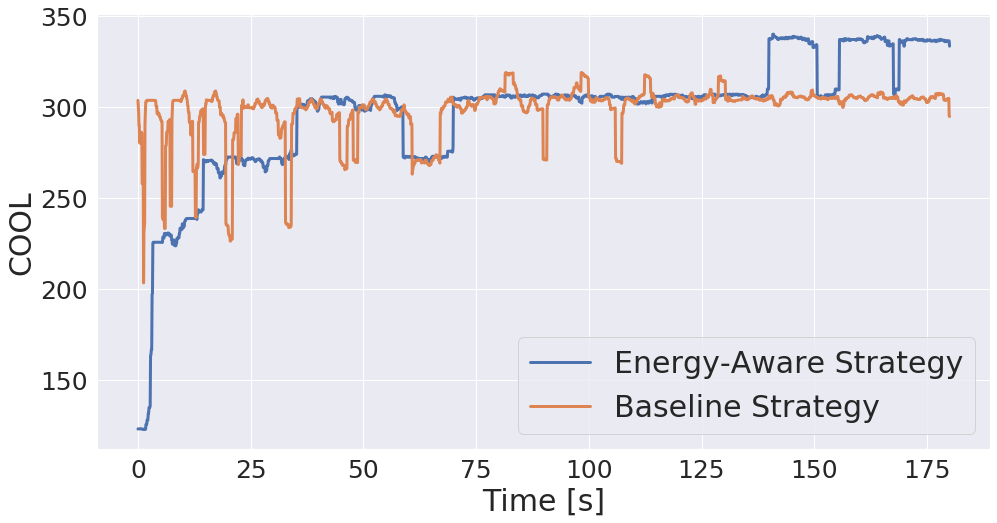

In [79]:
sim_time = 180
off=10
time_scaled = np.linspace(0, sim_time, len(scaled_df)-off)
time_2 = np.linspace(0, sim_time, len(df_2)-off)


plt.figure(figsize=(16,8))
plt.plot(time_scaled, scaled_df["total_cool"][off:], label="Energy-Aware Strategy", linewidth=3)
plt.plot(time_2, df_2["total_cool"][off:], label="Baseline Strategy", linewidth=3)
plt.ylabel("COOL", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

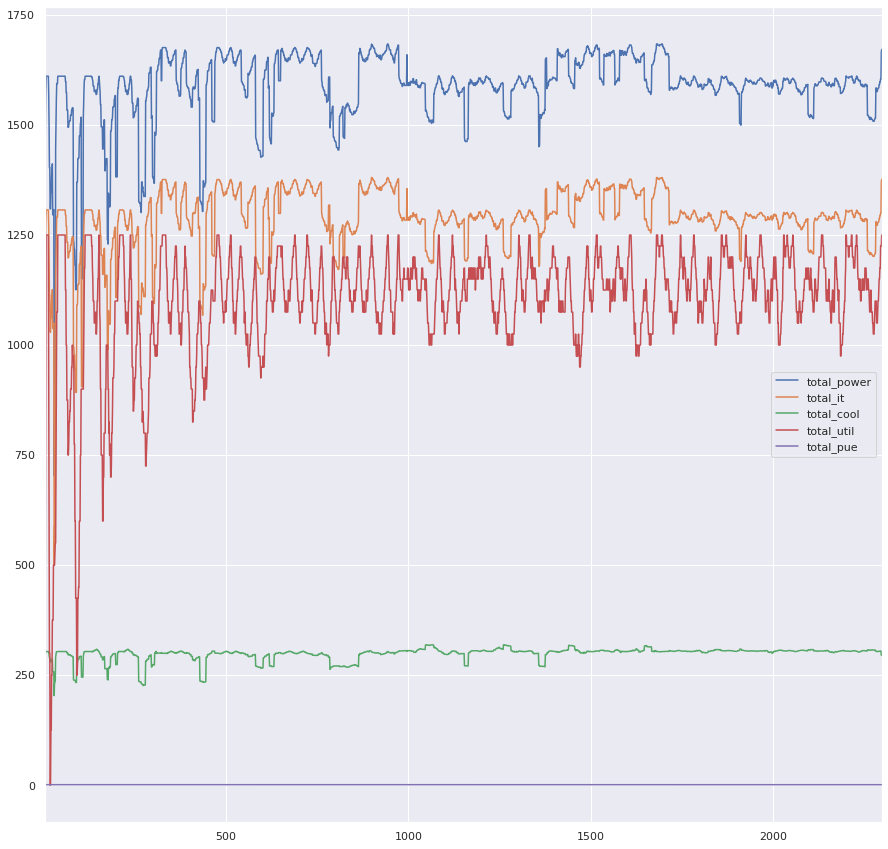

In [80]:
df_2.plot(y=[col for col in df_2.columns if "total" in col], figsize=(15,15))
plt.show()

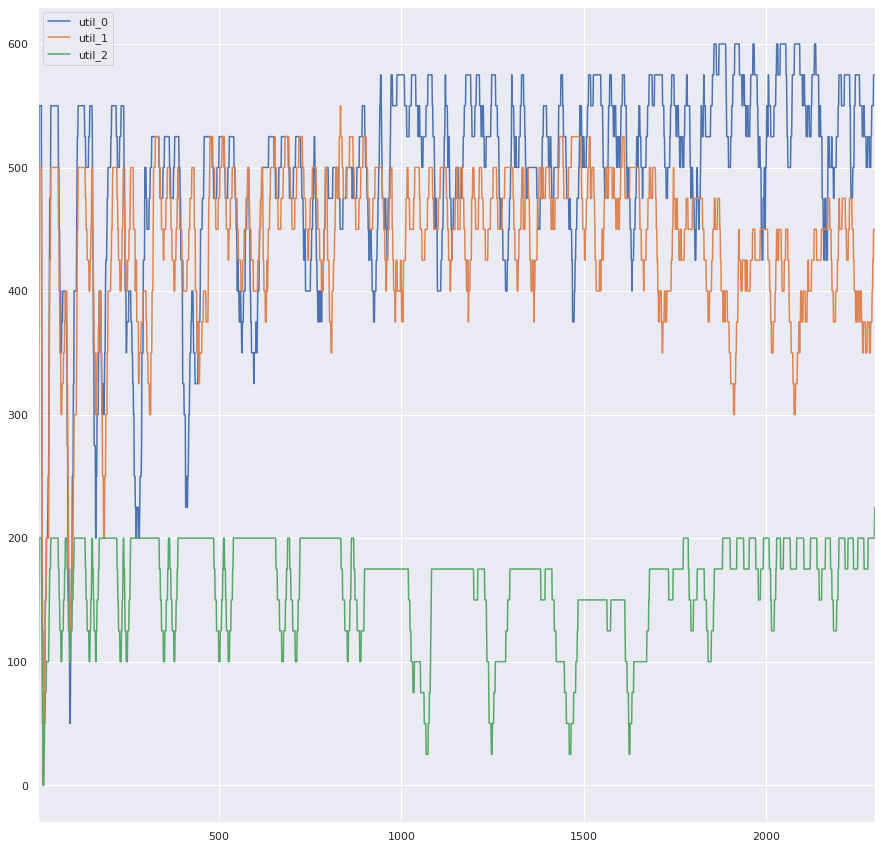

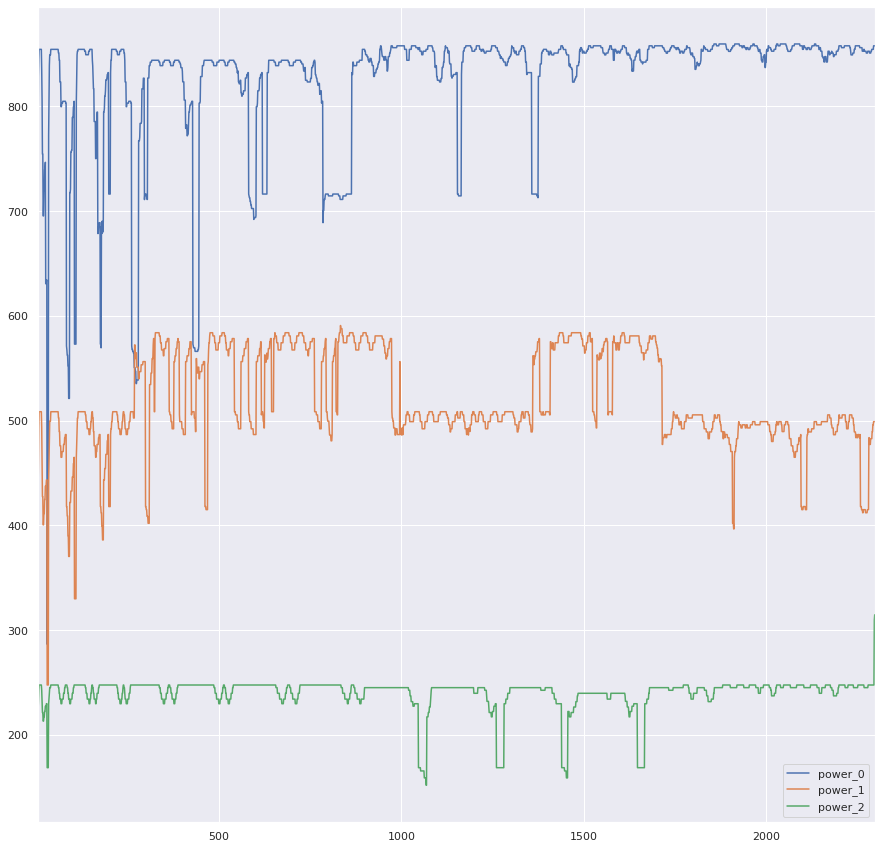

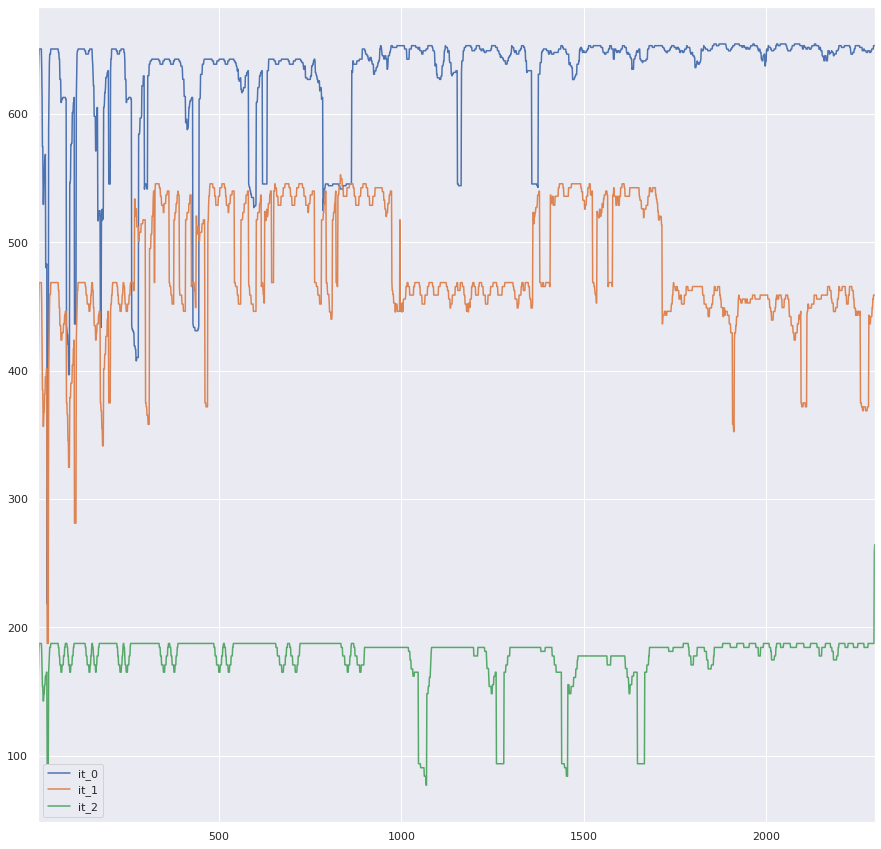

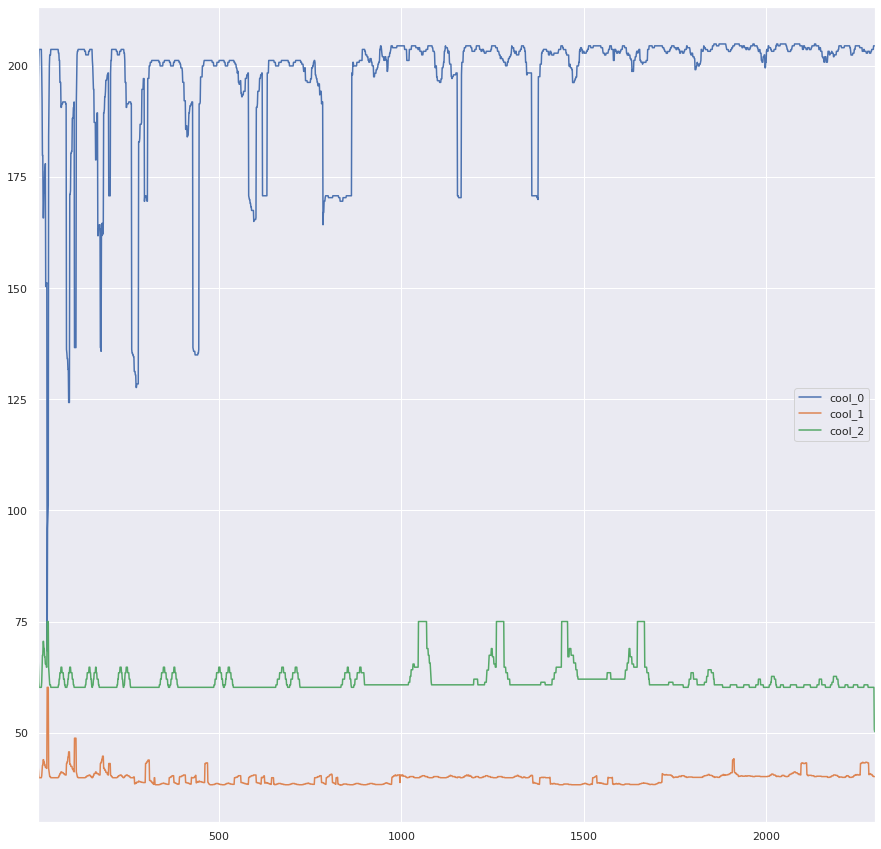

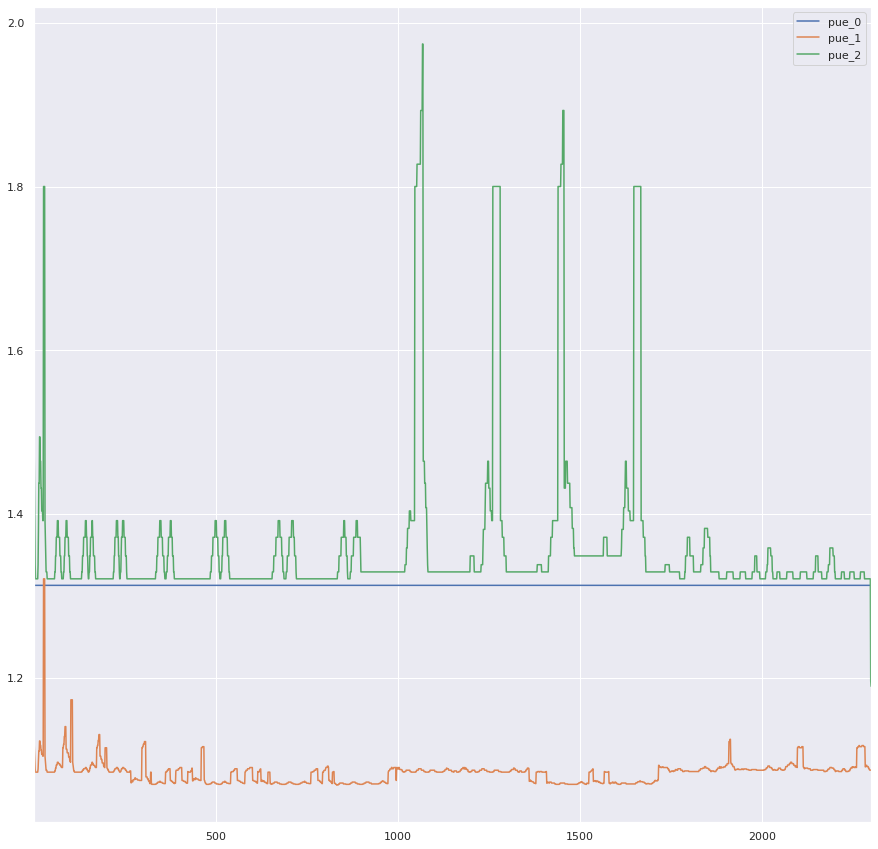

In [84]:
for col in ["util", "power", "it", "cool","pue"]:
    df_2.plot(y=[col+"_0", col+"_1", col+"_2"], figsize=(15,15))

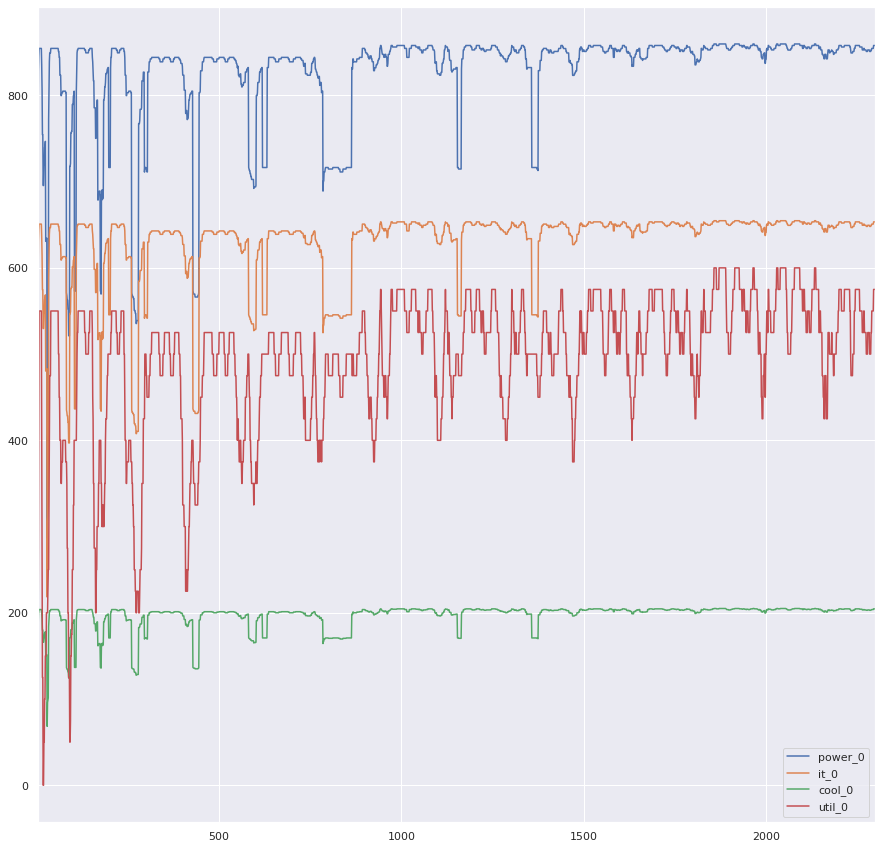

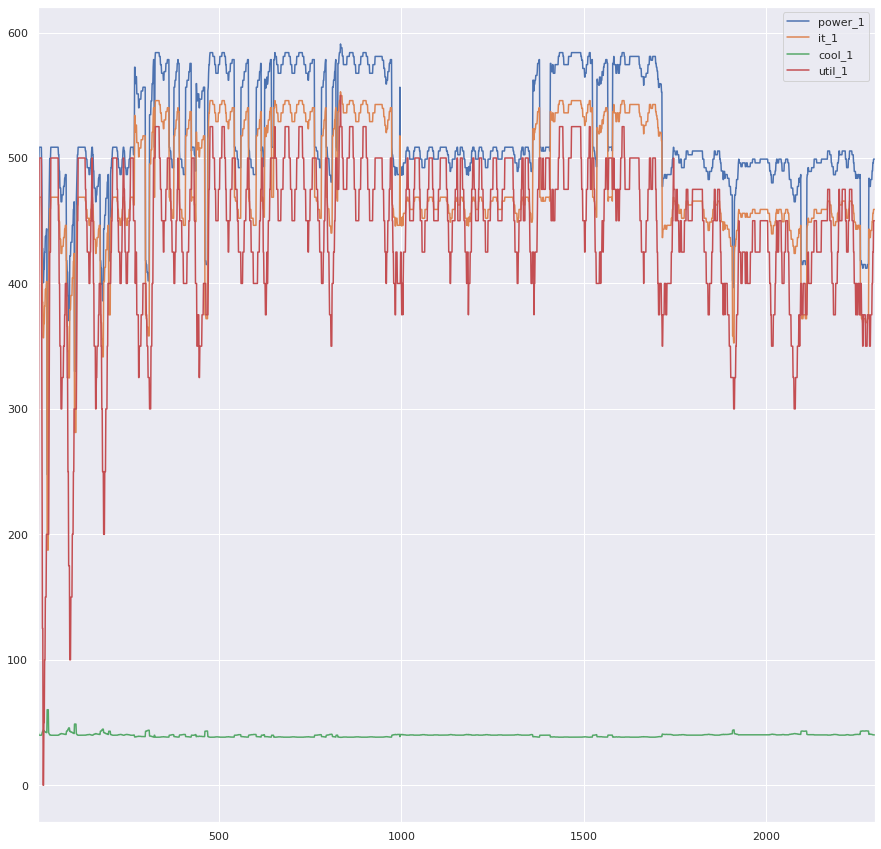

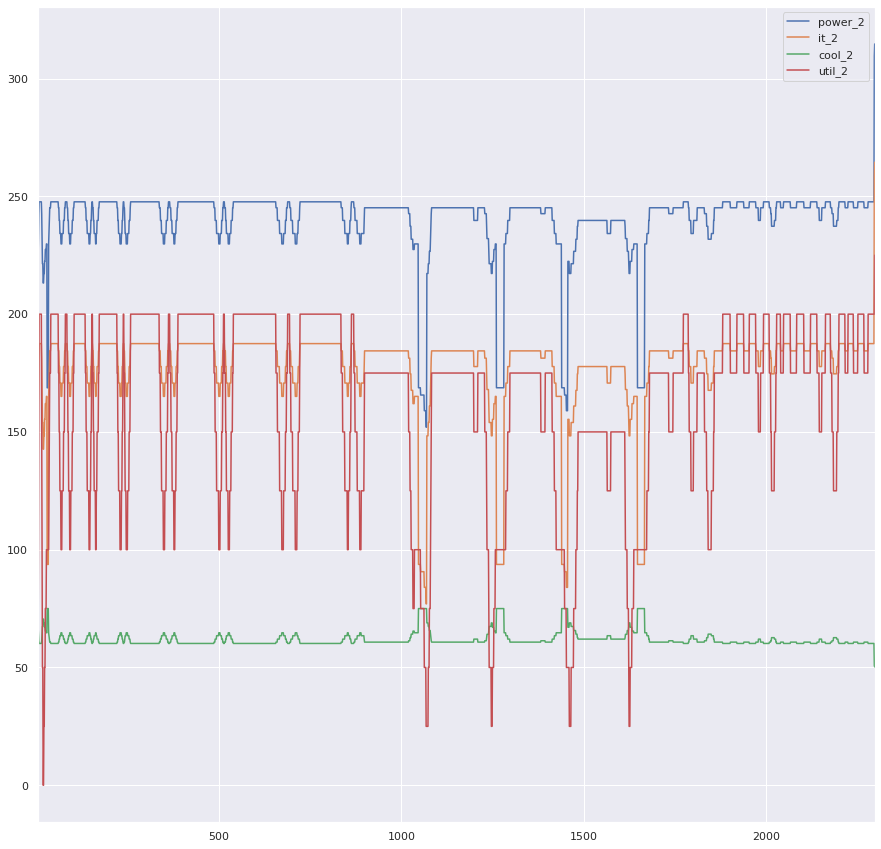

In [82]:
for i in range(3):
    df_2.plot(y=["power_"+str(i),"it_"+str(i),"cool_"+str(i),"util_"+str(i)], figsize=(15,15))

# Episodes: Loss, Mean Reward, etc.

In [83]:
! ls ../info

mercury_info_parsed


In [23]:
df_4 = pd.read_csv('../info/vanilla_a3c_training_results.csv',
                   delimiter=";",
                   names=["episodes", "length", "rewards", "loss", "entropies"])
df_4

,episodes,length,rewards,loss,entropies
0,0,7095,-1.231188e+07,0.337519,-0.001090
1,1,7133,-1.242599e+07,0.299998,-0.001082
2,2,7027,-1.215850e+07,0.238279,-0.001061


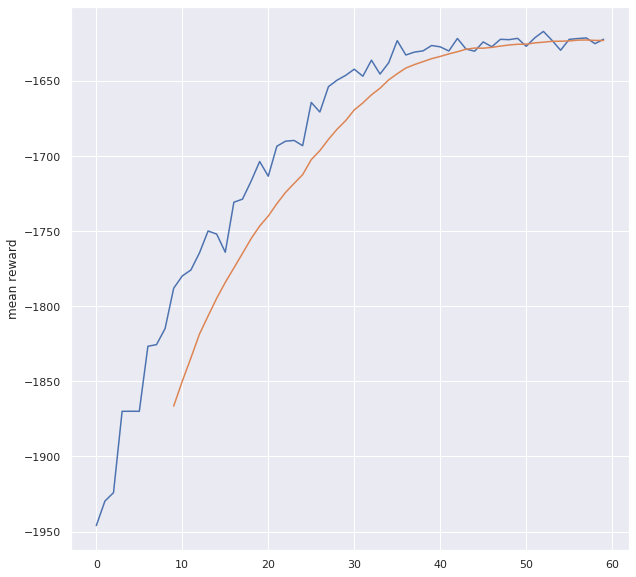

In [41]:
plt.figure(figsize=(10,10))
plt.plot(df_4["rewards"]/df_4["length"])
plt.plot(pd.Series.rolling(pd.Series(df_4["rewards"]/df_4["length"]), 10).mean())
plt.ylabel("mean reward")
plt.show()

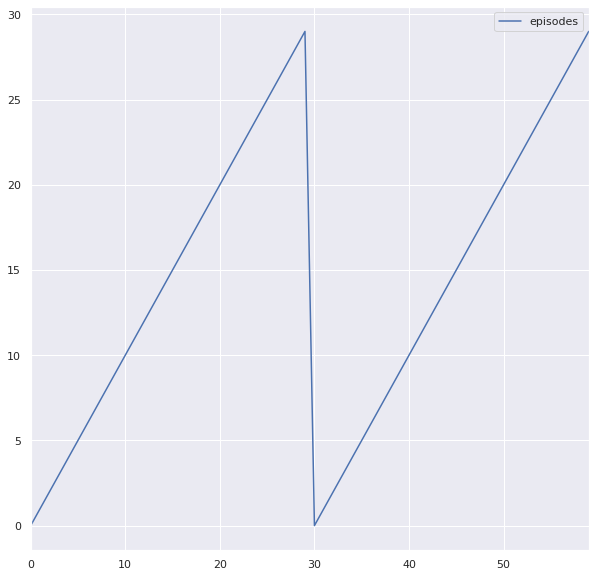

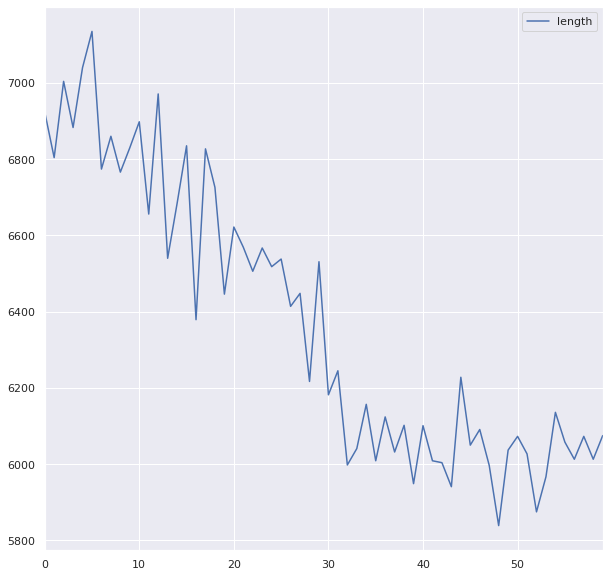

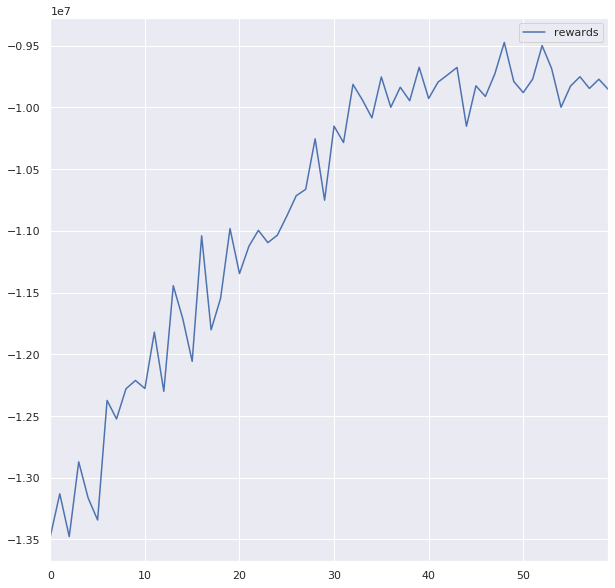

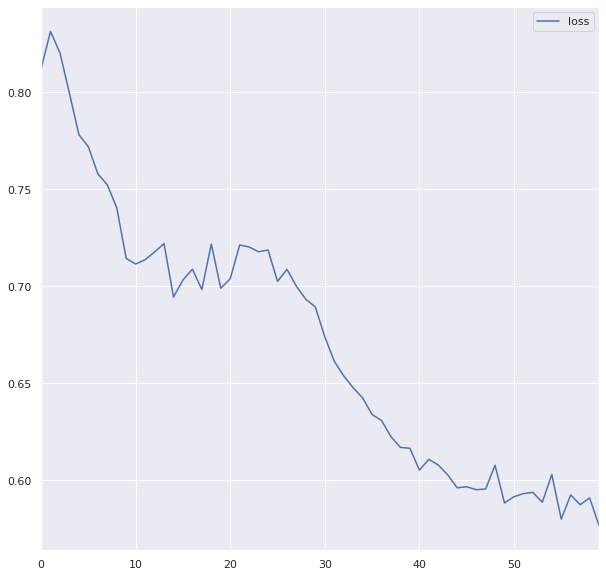

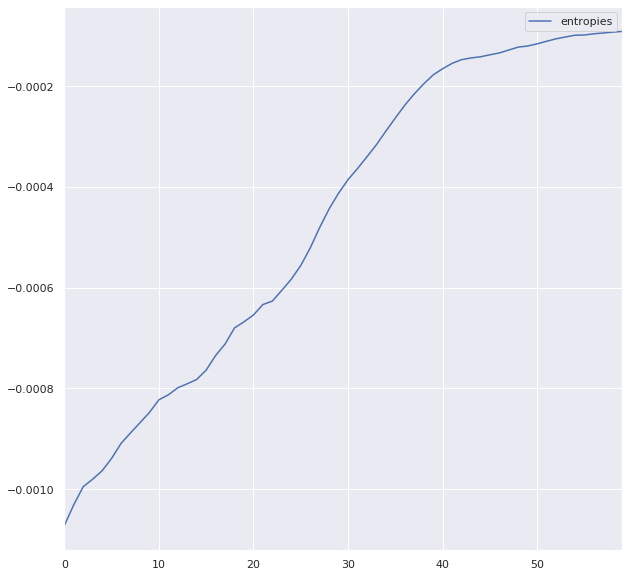

In [42]:
for col in df_4.columns:
    df_4.plot(y=col, figsize=(10,10))

In [45]:
#!cat ../info/vanilla_a3c_training_info.txt
!cat ../results/2_new_NN_architecture/4_results_report/0_air/gpu_5/training_info.txt

Saving intial model's weights!
Saving new best model's weights!
episode: 0, time: 84.7183039188385, length: 6924, mean reward: -1946.0480348971591, loss: 0.2704550325870514 0.5428288578987122 -0.0010725408792495728
Saving new best model's weights!
episode: 1, time: 82.25773215293884, length: 6804, mean reward: -1929.7326889621168, loss: 0.2804199457168579 0.552066445350647 -0.0010311342775821686
Saving new best model's weights!
episode: 2, time: 85.98856520652771, length: 7004, mean reward: -1924.119623729939, loss: 0.27627819776535034 0.5450607538223267 -0.0009952860418707132
Saving new best model's weights!
episode: 3, time: 88.7599709033966, length: 6883, mean reward: -1869.9744657920783, loss: 0.2563604414463043 0.5441180467605591 -0.000980385229922831
Saving new best model's weights!
episode: 4, time: 89.44399094581604, length: 7040, mean reward: -1869.9281580318104, loss: 0.24058465659618378 0.5385463237762451 -0.0009636111790314317
episode: 5, time: 89.16612577438354, length: 71

# Episodes (2nd Option)

### Training info file must be cleaned before!! (remove lines with no commas)

In [19]:
df_5 = pd.read_csv('../info/vanilla_a3c_training_info.txt',
                   delimiter=",",
                   names=["episodes", "time", "length", "mean rewards", "loss"])

def compute_loss(x):
    losses = x.split(":")[1].split(" ")
    return sum([float(l) for l in losses[1:]])

for col in df_5.columns[:-1]:
    df_5[col] = df_5[col].str.split(":").str[1].astype(np.float)
df_5["entropy"] =  df_5["loss"].str.split(":").str[1].str.split(" ").str[3].astype(np.float)
df_5["loss"] =  df_5["loss"].apply(compute_loss)
df_5

AttributeError: 'float' object has no attribute 'split'

In [ ]:
for col in df_5.columns:
    df_5.plot(y=col, figsize=(10,10))